<a href="https://colab.research.google.com/github/NathanPham04/184A_Final_Project/blob/main/CS184a_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data
https://www.kaggle.com/datasets/khushikyad001/covid-19-symptoms-and-severity-prediction-dataset/data

# Data Processing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./covid_symptoms_severity_prediction.csv')

## View of row data

In [5]:
# Get shape of data
print("Data Shape:", df.shape)
# Example first few rows of the data
display(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print('Missing values in each column:')
print(missing_values)

Data Shape: (3000, 17)


,age,gender,vaccination_status,fever,cough,fatigue,shortness_of_breath,loss_of_smell,headache,diabetes,hypertension,heart_disease,asthma,cancer,hospitalized,icu_admission,mortality
0,51,Male,Unvaccinated,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,92,Male,Fully Vaccinated,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,14,Male,Fully Vaccinated,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,71,Male,Fully Vaccinated,1,1,0,0,0,0,0,1,0,0,0,0,0,0
4,60,Male,Unvaccinated,0,1,1,1,1,0,1,1,1,0,0,1,1,0


Missing values in each column:
age                    0
gender                 0
vaccination_status     0
fever                  0
cough                  0
fatigue                0
shortness_of_breath    0
loss_of_smell          0
headache               0
diabetes               0
hypertension           0
heart_disease          0
asthma                 0
cancer                 0
hospitalized           0
icu_admission          0
mortality              0
dtype: int64


## Visualization of distribution

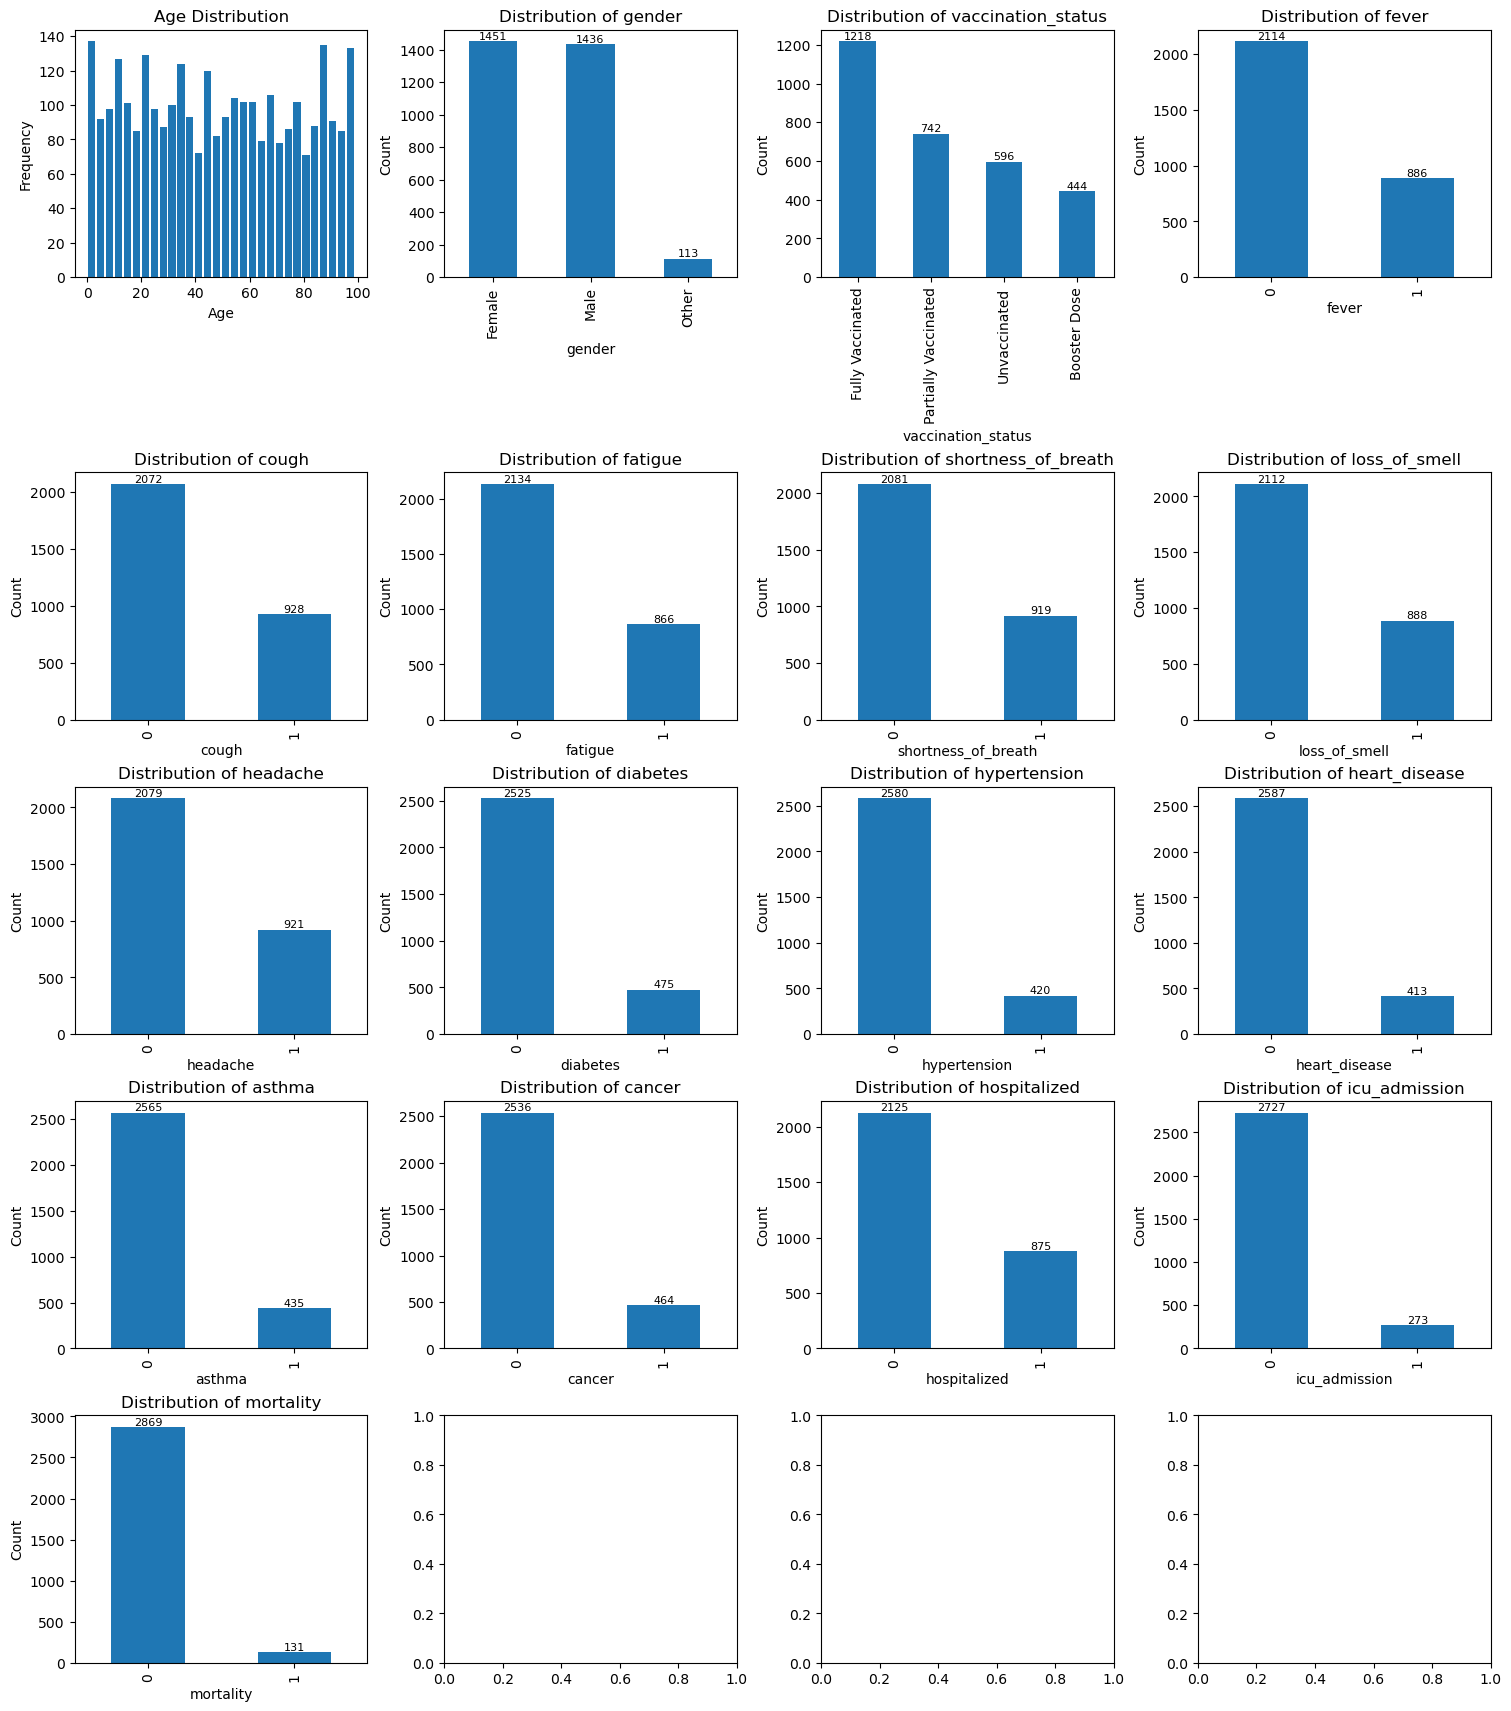

In [6]:
# Plotting the distribution of each column 
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 17), constrained_layout=True)

for i, column in enumerate(df.columns):
    ax = axes[i // 4, i % 4]
    if i == 17:
        break
    # If the column is age use histogram
    if column == 'age':
        df[column].plot(kind='hist', bins=30, rwidth=0.8, ax=ax)
        ax.set_title('Age Distribution')
        ax.set_xlabel('Age')
        ax.set_ylabel('Frequency')
    else:   
        counts = df[column].value_counts()
        counts.plot(kind='bar', ax=ax)

        # Add count labels on each bar
        for idx, value in enumerate(counts.values):
            ax.text(
                idx,                         # x position
                value,                        # y position (top of bar)
                str(value),                   # text label
                ha='center', va='bottom',     # position alignment
                fontsize=8
            )

        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
plt.show()

## Correlation Heatmap

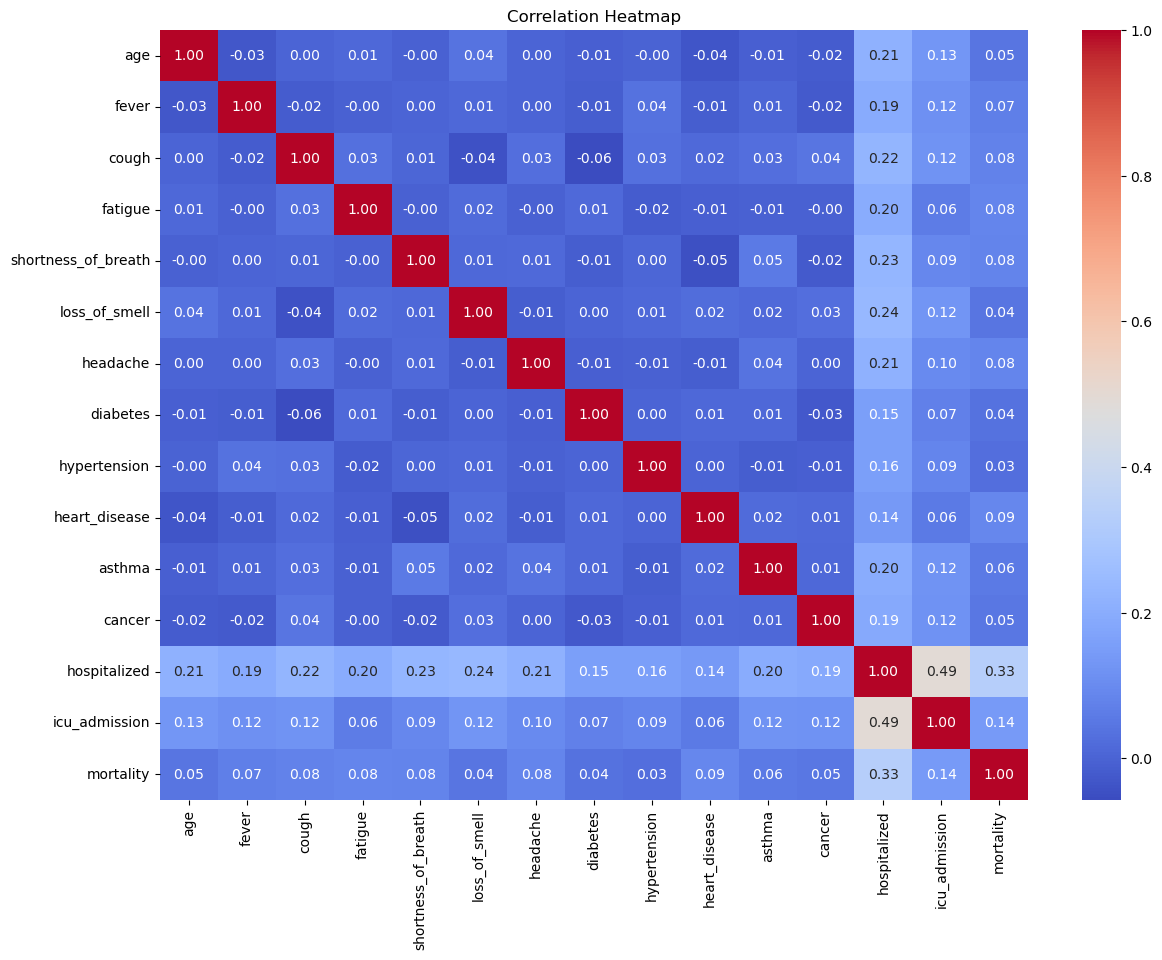

In [7]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Training and Validation Split

In [8]:
from sklearn.model_selection import train_test_split

# 80% train, 20% validation
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=67,   # ensures reproducibility
    shuffle=True,
    stratify=df['mortality']  # stratify based on mortality to maintain distribution
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))

Train size: 2400
Validation size: 600


In [10]:
target_col = 'mortality'

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]


Index(['gender', 'vaccination_status'], dtype='object')


In [11]:
# encode categorical data as hot-ones for mlp model
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
print("Categorical columns detected:", list(categorical_cols))

if len(categorical_cols) > 0:
    X_train_enc = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
    X_val_enc = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True)
    X_val_enc = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)
else:
    X_train_enc = X_train.copy()
    X_val_enc = X_val.copy()

Categorical columns detected: ['gender', 'vaccination_status']


# MLP

In [31]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_val_scaled = scaler.transform(X_val_enc)

## Model 1

In [34]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, ),
    activation='relu',
    solver='adam',
    random_state=67,
    max_iter=1000
)

mlp.fit(X_train_scaled, y_train)
y_val_pred = mlp.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\nValidation Accuracy: {val_accuracy:.4f}\n")
print("Classification report on validation set:")
print(classification_report(y_val, y_val_pred))



Validation Accuracy: 0.9383

Classification report on validation set:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       574
           1       0.08      0.04      0.05        26

    accuracy                           0.94       600
   macro avg       0.52      0.51      0.51       600
weighted avg       0.92      0.94      0.93       600



#### Observation
The model achieves a high validation accuracy of 93.8%, but this performance is misleading due to extreme class imbalance. While the classifier performs very well on the majority class (class 0, with precision 0.96 and recall 0.98), it performs poorly on the minority class (class 1), detecting only 4% of actual death cases and achieving an F1-score of 0.05. This indicates that the model is overwhelmingly biased toward predicting survival and fails to meaningfully identify high-risk patients. Despite the strong accuracy and weighted averages, the model is ineffective for the minority class and provides no practical value for mortality prediction, where correctly identifying the positive class is critical.

## Model 2

In [36]:
# if class is rare, higher weight aka give preference to deaths (class 1) since few data
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, class_weights))
sample_weight = y_train.map(class_weight_dict)

mlp = MLPClassifier(
    hidden_layer_sizes=(64,), 
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    random_state=67,
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1
)

mlp.fit(X_train_scaled, y_train, sample_weight=sample_weight)
y_val_pred = mlp.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\nValidation Accuracy: {val_accuracy:.4f}\n")
print("Classification report on validation set:")
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.7433

Classification report on validation set:
              precision    recall  f1-score   support

           0       1.00      0.73      0.85       574
           1       0.14      1.00      0.25        26

    accuracy                           0.74       600
   macro avg       0.57      0.87      0.55       600
weighted avg       0.96      0.74      0.82       600



### Observation
The model achieved a lower overall accuracy (74%) compared to earlier runs, but it shows a dramatic improvement in detecting the minority “death” class. The recall for class 1 increased to 1.00, meaning the model successfully identified every actual death in the validation set — a crucial outcome in medical prediction tasks where missing positive cases is highly dangerous. However, this comes at the cost of precision (0.14) and reduced accuracy for class 0, since the model now predicts many survivors as deaths. Overall, the model prioritizes sensitivity over specificity, trading false positives for zero false negatives in class 1.

# Manual Selection of Features Using Heatmap

In [18]:
# TODO Nathan

# Manual Selection of Features with Groupings of 5

In [ ]:
# TODO Puru

# Automatic L1 Regularization

In [ ]:
# TODO Leanne

# Analysis and Performance

In [ ]:
# TODO